In [ ]:
!pip install pyspark==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285391 sha256=2e5d0cbb71697d018f86888101498da5c3718ea32cde2093130c45b79c74b489
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


Tugas 1: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



Tugas 2: Buat SQL query yang menghitung total gaji berdasarkan jenis kelamin dan usia.

In [ ]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



**Tugas Tambahan 2:**



*   Cari rata-rata gaji per departemen.





In [ ]:
spark.sql('''
SELECT DeptId, AVG(Salary) as AvarageSalary
FROM employees
GROUP BY DeptId
''').show()

+------+-------------+
|DeptId|AvarageSalary|
+------+-------------+
|     1|       2850.0|
|     2|       4100.0|
+------+-------------+





*   Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing




In [ ]:
spark.sql('''
SELECT a.*
FROM employees a
JOIN (
    SELECT Gender, AVG(Salary) as AvgSalary
    FROM employees
    GROUP BY Gender
) avg_gender ON a.Gender = avg_gender.Gender
WHERE a.Salary > avg_gender.AvgSalary
''').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
+-----+---+------+------+------+




*   Buat ranking karyawan berdasarkan gaji dalam departemen mereka.



In [ ]:
spark.sql('''
SELECT DeptId, Salary, ROW_NUMBER() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as rank
FROM employees
''').show()

+------+------+----+
|DeptId|Salary|rank|
+------+------+----+
|     1|  3000|   1|
|     1|  2700|   2|
|     2|  4100|   1|
+------+------+----+



Tugas 3: Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu.

In [ ]:
spark.sql('''
SELECT DeptId, Salary, ROW_NUMBER() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as rank
FROM employees
''').show()


+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



Tugas 4: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()


+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



Tugas 5: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.

In [ ]:
avg_salary_per_dept = spark.sql('''
SELECT DeptId, AVG(Salary) as AvgSalary
FROM employees
GROUP BY DeptId
''')

from pyspark.sql.window import Window
from pyspark.sql import functions as F

rank_window = Window.partitionBy("DeptId").orderBy(F.desc("Salary"))
ranked_employees = employees.withColumn("Rank", F.rank().over(rank_window))

avg_salary_per_dept.show()
ranked_employees.show()

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+

+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|Rank|
+-----+---+------+------+------+----+
|James| 34|     M|  3000|     1|   1|
|  Lee| 23|     M|  2700|     1|   2|
| Anna| 28|     F|  4100|     2|   1|
+-----+---+------+------+------+----+



Tugas 6: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.

In [ ]:
salary_trends_window = Window.partitionBy("DeptId").orderBy("Age")
salary_trends_by_age = employees.withColumn("SalaryTrend", F.avg("Salary").over(salary_trends_window))

salary_trends_by_age.show()

+-----+---+------+------+------+-----------+
| Name|Age|Gender|Salary|DeptId|SalaryTrend|
+-----+---+------+------+------+-----------+
|  Lee| 23|     M|  2700|     1|     2700.0|
|James| 34|     M|  3000|     1|     2850.0|
| Anna| 28|     F|  4100|     2|     4100.0|
+-----+---+------+------+------+-----------+



Tugas 7: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.

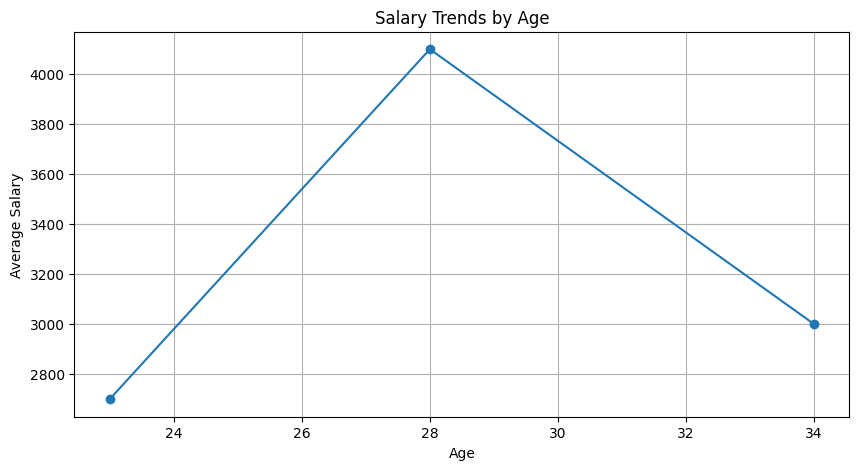

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

**Homework**

Tugas 1: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.

+------+-----------+-------------+
|DeptId|TotalSalary|EmployeeCount|
+------+-----------+-------------+
|     1|      11700|            3|
|     2|       7600|            2|
+------+-----------+-------------+



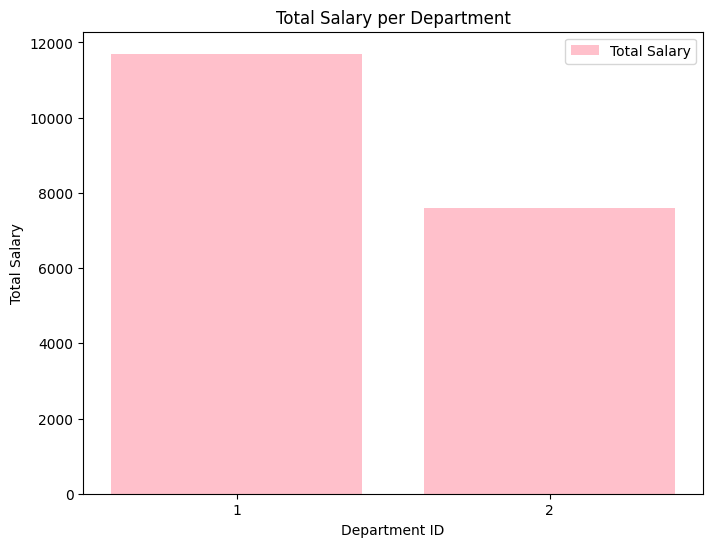

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Robert', 34, 'M', 6000, 1),
    ('Maria', 28, 'F', 3500, 2)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('perusahaan')

tugas_1 = spark.sql('''
    SELECT DeptId, SUM(Salary) AS TotalSalary, COUNT(Name) AS EmployeeCount
    FROM perusahaan
    GROUP BY DeptId
''')
tugas_1.show()

import matplotlib.pyplot as plt
tugas_1_pd = tugas_1.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(tugas_1_pd['DeptId'], tugas_1_pd['TotalSalary'], color='pink', label='Total Salary')
plt.xticks(tugas_1_pd['DeptId'])
plt.xlabel('Department ID')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')
plt.legend()
plt.show()

Tugas 2: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.

+------+---+------+
|  Name|Age|Salary|
+------+---+------+
|  Anna| 28|  4100|
|Robert| 34|  6000|
+------+---+------+



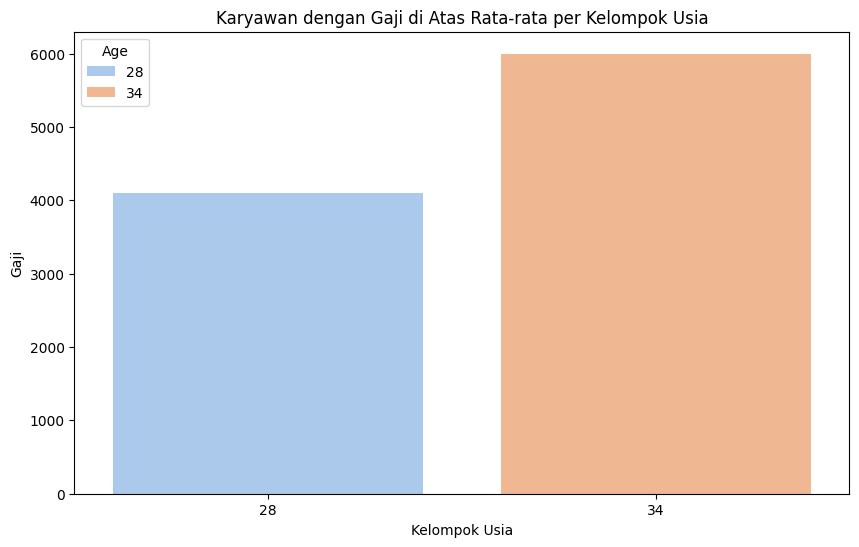

In [ ]:
avg_salary_by_age = spark.sql('''
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM perusahaan
    GROUP BY Age
''')

avg_salary_by_age.createOrReplaceTempView("avg_salary_by_age")
above_avg_perusahaan = spark.sql('''
    SELECT e.Name, e.Age, e.Salary
    FROM perusahaan e
    JOIN avg_salary_by_age a ON e.Age = a.Age
    WHERE e.Salary > a.AvgSalary
''')
above_avg_perusahaan.show()

import seaborn as sns

above_avg_perusahaan_pd = above_avg_perusahaan.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='Salary', hue='Age', data=above_avg_perusahaan_pd, palette='pastel')
plt.xlabel('Kelompok Usia')
plt.ylabel('Gaji')
plt.title('Karyawan dengan Gaji di Atas Rata-rata per Kelompok Usia')
plt.xlabel('Kelompok Usia')
plt.ylabel('Gaji')
plt.show()

Tugas 3: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti SUM(), AVG(), COUNT(), serta JOIN antar tabel serta buat visualisasi yang menarik.

+------+--------------+-----------+---------+
|DeptId|TotalEmployees|TotalSalary|AvgSalary|
+------+--------------+-----------+---------+
|     1|           150|     585000|   3900.0|
|     2|           100|     380000|   3800.0|
+------+--------------+-----------+---------+



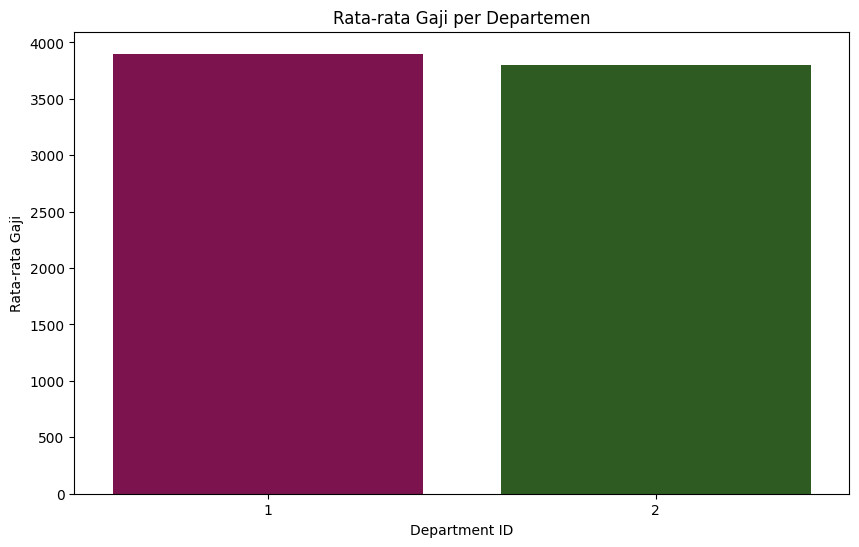

In [ ]:
big_data = [("James", 34, "M", 3000, 1), ("Anna", 28, "F", 4100, 2), ("Lee", 23, "M", 2700, 1), ('Robert', 34, 'M', 6000, 1), ('Maria', 28, 'F', 3500, 2)] * 50
df_big = spark.createDataFrame(big_data, schema=columns)
df_big.createOrReplaceTempView('perusahaan_besar')

tugas_3 = spark.sql('''
    SELECT DeptId, COUNT(Name) AS TotalEmployees, SUM(Salary) AS TotalSalary, AVG(Salary) AS AvgSalary
    FROM perusahaan_besar
    GROUP BY DeptId
''')
tugas_3.show()

import seaborn as sns
tugas_3_pd = tugas_3.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='DeptId', y='AvgSalary', hue='DeptId', data=tugas_3_pd, palette='PiYG', legend=False)
plt.title('Rata-rata Gaji per Departemen')
plt.xlabel('Department ID')
plt.ylabel('Rata-rata Gaji')
plt.show()
